In [1]:
import time
import mne
from esinet.minimum_norm import mne_eloreta
from esinet.simulation import Simulation
from esinet.forward import create_forward_model, get_info
from esinet.net import Net
from esinet.util import wrap_mne_inverse, unpack_fwd

info = get_info()
info['sfreq'] = 100
fwd = create_forward_model(info=info)
pos = unpack_fwd(fwd)[2]


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.9s remaining:    6.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    5.0s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


(1284, 3)
Simulating data based on sparse patches.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 61, 20)


In [31]:
settings = dict(duration_of_trial=0.2, number_of_sources=20)
sim = Simulation(fwd, info, settings=settings, parallel=False)

n_samples = 1
sim.simulate(n_samples=n_samples)

epochs = sim.eeg_data
data = epochs.get_data()
print(data.shape)

Simulating data based on sparse patches.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(1, 61, 20)


In [38]:
import numpy as np
np.asarray(img)

(12, 12)

array([[        nan, -0.51823303, -0.11884859, -0.05493736, -0.46857304,
        -1.90294255, -2.35451509, -2.3110399 , -2.73759248, -1.92260688,
        -1.45145659,         nan],
       [-1.85504826, -1.52895566,  0.01233474,  0.04860051, -0.08562395,
        -0.70668551, -1.10295828, -1.70949241, -2.14087364, -1.67827339,
        -1.17670718, -0.47340707],
       [-2.38302631, -2.31943083, -0.10525667,  0.50139255,  0.23793099,
         0.65032084,  1.26664611,  0.76535991, -1.38614709, -1.58301056,
        -0.27514963,  0.57724325],
       [-1.83670468, -1.9172088 , -0.67403257,  0.09670578,  0.28439472,
        -0.28011173, -0.04921741,  0.17798393, -1.77402465, -1.14360143,
         1.04287071,  1.37055396],
       [-1.33160829, -0.45398503,  0.52386574,  0.58550177,  0.513919  ,
         1.35272472,  1.55263541,  0.34443854, -1.0658983 , -0.96401001,
         1.10772784,  0.68525557],
       [-1.08231038,  0.11206209,  0.88094441,  0.40356625, -0.19638124,
        -0.45123854,  

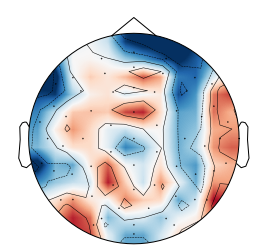

In [51]:
def elec_transformer(pos):
    def trans(vec):
        im, _ = mne.viz.plot_topomap(vec, pos, show=False, res=12)
        img = np.asarray(im.get_array()[::-1])
        return img

    return trans

foo = elec_transformer(elec_pos)

foo(np.random.randn(61,))

In [53]:
# elec_pos = _find_topomap_coords(epochs.info, epochs.ch_names)
net.Info

NameError: name 'net' is not defined

0.0748436450958252  s


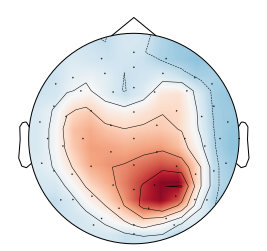

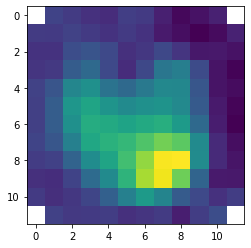

In [41]:
from mne.channels.layout import _find_topomap_coords

elec_pos = _find_topomap_coords(epochs.info, epochs.ch_names)

# epochs.info
start = time.time()
im, _ = mne.viz.plot_topomap(data[0,:, 0], elec_pos, show=False, res=12)
# img = im.get_array()[::-1]
img = np.asarray(im.get_array()[::-1])
end = time.time()
print((end-start), ' s')
plt.figure()
plt.imshow(img)


In [49]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.models import Sequential
n_filters = 8
kernel_size = (3, 3)
n_units = 512
activation = 'relu'
output_shape = sim.source_data[0].data.shape[0]

model = Sequential()
model.add(Conv2D(n_filters, kernel_size, activation=activation))
model.add(Flatten())
model.add(Dense(n_units, activation=activation))
model.add(Dense(output_shape, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')



In [55]:
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
n = 100

y_true = np.random.randn(n, 20)
y_pred = y_true + np.random.randn(n, 20)*0.5

corrs = np.zeros(n)
cosines = np.zeros(n)
mses = np.zeros(n)
nmses = np.zeros(n)

for i, (t, p) in enumerate(zip(y_true, y_pred)):
    mses[i] = np.mean((t-p)**2)
    nmses[i] = np.mean((t/np.max(np.abs(t)) - p/np.max(np.abs(p)))**2)
    corrs[i] = pearsonr(t, p)[0]
    cosines[i] = cosine(t,p)
    


Text(0.5, 1.0, 'Corr: 0.6797450865227515')

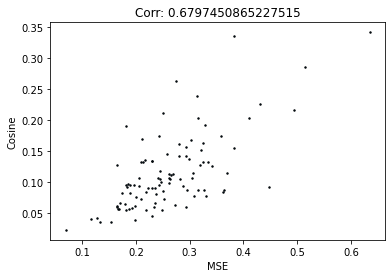

In [67]:
var = np.stack([mses, cosines], axis=0)
names = ['MSE', 'Cosine']
r = pearsonr(var[0], var[1])[0]
title = f'Corr: {r}'
plt.figure()
plt.scatter(var[0], var[1], edgecolors='k', s=2)
lo_lim = np.nanmin(var)
hi_lim = np.nanmax(var)
# plt.plot([lo_lim, hi_lim], [lo_lim, hi_lim], '--r')
plt.xlabel(names[0])
plt.ylabel(names[1])
plt.title(title)